# Benchmarks

- **Well-conditioned quadratic functions**
- **Ill-conditioned quadratic function**
- **Rosenbrock function**
- **MNIST Neural Network Training** - `In different file`

## Extra Benchmarks

- **Rastrigin Function**
- **Ackley Function**
- **Himmelblau Function**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Quadratic function generator
# -------------------------------
def generate_quadratic(dim=10, cond_number=10):
    """Generate symmetric positive definite Q with given condition number."""
    V = np.linalg.qr(np.random.randn(dim, dim))[0]  # orthogonal matrix
    eigvals = np.linspace(1, cond_number, dim)      # spread of eigenvalues
    Q = V @ np.diag(eigvals) @ V.T
    return Q

# Quadratic function and gradient
def quadratic_f(x, Q):
    return 0.5 * x.T @ Q @ x

def quadratic_grad(x, Q):
    return Q @ x

# Rosenbrock function and gradient
def rosenbrock_f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

# -------------------------------
# Optimizers (with loss tracking)
# -------------------------------
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=10000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x); losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        v = beta * v + (1 - beta) * g
        x -= lr * v
    return x, i + 1, losses

def adam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    losses = []
    for t in range(1, max_iter + 1):
        loss = f(x); losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return x, t, losses

def rmsprop(f, grad_f, x0, lr=0.001, beta=0.9, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    s = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x); losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        s = beta * s + (1 - beta) * (g ** 2)
        x -= lr * g / (np.sqrt(s) + eps)
    return x, i + 1, losses

# ---------------------------------------------------------
# UMG Optimizer
# ---------------------------------------------------------
def umg(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999,
        eps=1e-8, scale_bad=0.5, tol=1e-6, max_iter=10000):

    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    prev_diff = np.zeros_like(x) + np.inf
    t = 0
    losses = []

    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)

        g_old = grad_f(x)
        if np.linalg.norm(g_old) < tol:
            break

        t += 1

        # Adam moments
        m = beta1 * m + (1 - beta1) * g_old
        v = beta2 * v + (1 - beta2) * (g_old * g_old)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # tentative update
        x_new = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        # compare gradient directions
        g_new = grad_f(x_new)
        diff_norm = np.linalg.norm(g_new - g_old)

        scale = 1.0 if diff_norm < np.linalg.norm(prev_diff) else scale_bad

        # reinforce/dampen m
        m = beta1 * m + (1 - beta1) * g_old * scale

        prev_diff = g_new - g_old
        x = x_new

    return x, i + 1, losses

# -------------------------------
# Experiment Runner + Plotter
# -------------------------------
def run_and_plot(f, grad_f, x0, optimizers, tol, f_name, logy=True):
    plt.figure(figsize=(7, 5))
    for name, opt in optimizers.items():
        x_opt, n_iter, losses = opt(f, grad_f, x0)
        print(f"{f_name} | {name} converged in {n_iter} iterations.")
        plt.plot(losses, label=name)
    if logy:
        plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Loss value")
    plt.title(f"Loss Decay: {f_name}")
    plt.legend()
    plt.grid(True)
    plt.show()




--- Well-Conditioned Quadratic ---
Well-Conditioned Quadratic | SGD+Momentum converged in 1260 iterations.
Well-Conditioned Quadratic | Adam converged in 846 iterations.
Well-Conditioned Quadratic | RMSProp converged in 10000 iterations.
Well-Conditioned Quadratic | UMG converged in 904 iterations.


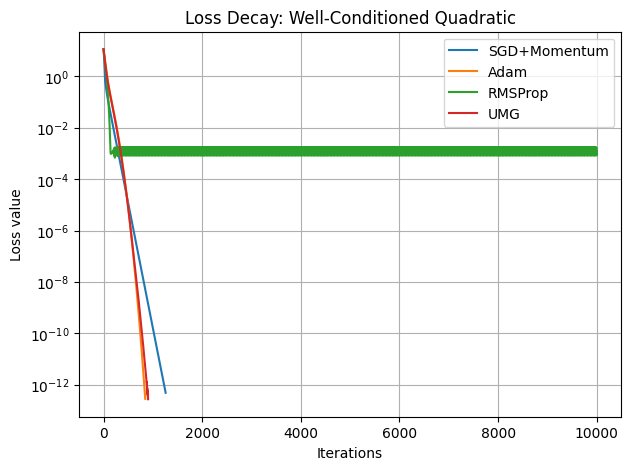

In [2]:

# ============================================================
# 1. Well-conditioned Quadratic
# ============================================================
print("\n--- Well-Conditioned Quadratic ---")
dim = 10
Q_well = generate_quadratic(dim, cond_number=10)
x0 = np.random.randn(dim)

optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.01),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.01),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.01),
    "UMG": lambda f, g, x0=x0: umg(f, g, x0, lr=0.01)
}

run_and_plot(lambda x: quadratic_f(x, Q_well),
             lambda x: quadratic_grad(x, Q_well),
             x0, optimizers, tol=1e-6, f_name="Well-Conditioned Quadratic")



--- Ill-Conditioned Quadratic ---
Ill-Conditioned Quadratic | SGD+Momentum converged in 10000 iterations.
Ill-Conditioned Quadratic | Adam converged in 10000 iterations.
Ill-Conditioned Quadratic | RMSProp converged in 10000 iterations.
Ill-Conditioned Quadratic | UMG converged in 10000 iterations.


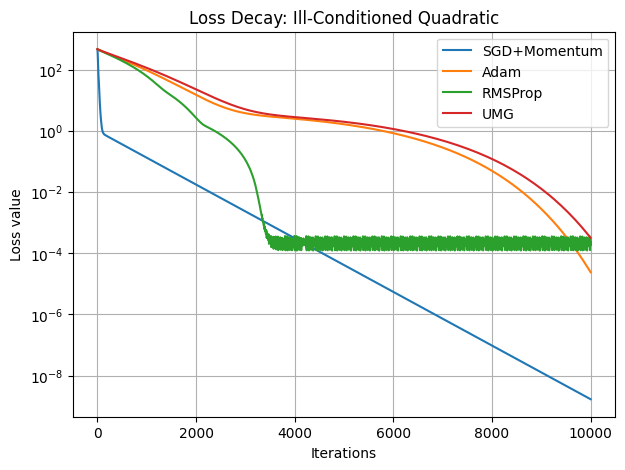

In [3]:

# ============================================================
# 2. Ill-conditioned Quadratic
# ============================================================
print("\n--- Ill-Conditioned Quadratic ---")
Q_ill = generate_quadratic(dim, cond_number=200)
x0 = np.random.randn(dim)

optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001),
    "UMG": lambda f, g, x0=x0: umg(f, g, x0, lr=0.001)
}

run_and_plot(lambda x: quadratic_f(x, Q_ill),
             lambda x: quadratic_grad(x, Q_ill),
             x0, optimizers, tol=1e-6, f_name="Ill-Conditioned Quadratic")



--- Rosenbrock Function ---


Rosenbrock Function | SGD+Momentum converged in 10000 iterations.
Rosenbrock Function | Adam converged in 10000 iterations.
Rosenbrock Function | RMSProp converged in 10000 iterations.
Rosenbrock Function | UMG converged in 10000 iterations.


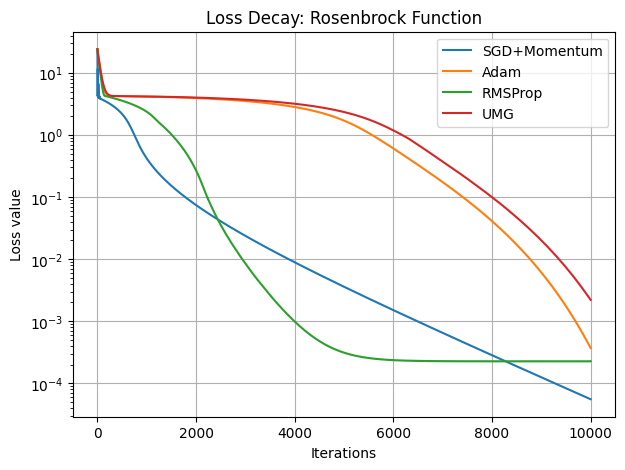

In [4]:

# ============================================================
# 3. Rosenbrock
# ============================================================
print("\n--- Rosenbrock Function ---")
x0 = np.array([-1.2, 1.0])

optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, tol=1e-4),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, tol=1e-4),
    "UMG": lambda f, g, x0=x0: umg(f, g, x0, lr=0.001, tol=1e-4)
}

run_and_plot(rosenbrock_f, rosenbrock_grad,
             x0, optimizers, tol=1e-4, f_name="Rosenbrock Function")


# Extra Benchmarks

In [5]:

# ============================================================
# Rastrigin
# ============================================================
def rastrigin_f(x):
    x = np.array(x)
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rastrigin_grad(x):
    x = np.array(x)
    A = 10
    return 2 * x + A * 2 * np.pi * np.sin(2 * np.pi * x)

# ============================================================
# Ackley
# ============================================================
def ackley_f(x):
    x = np.array(x)
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)
    term1 = -a * np.exp(-b * np.sqrt(np.sum(x*x) / d))
    term2 = -np.exp(np.sum(np.cos(c * x)) / d)
    return term1 + term2 + a + np.e

def ackley_grad(x):
    x = np.array(x)
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)

    r = np.sqrt(np.sum(x*x) / d)
    if r == 0:
        r = 1e-12

    grad1 = a * b * (x / (d * r)) * np.exp(-b * r)
    grad2 = c * np.sin(c * x) / d * np.exp(np.sum(np.cos(c*x)) / d)
    return grad1 + grad2

# ============================================================
# Himmelblau
# ============================================================
def himmelblau_f(x):
    x1, x2 = x
    return (x1*x1 + x2 - 11)**2 + (x1 + x2*x2 - 7)**2

def himmelblau_grad(x):
    x1, x2 = x
    df_dx = 4*x1*(x1*x1 + x2 - 11) + 2*(x1 + x2*x2 - 7)
    df_dy = 2*(x1*x1 + x2 - 11) + 4*x2*(x1 + x2*x2 - 7)
    return np.array([df_dx, df_dy])

# ============================================================
# Optimizers
# ============================================================
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=5000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        v = beta*v + (1-beta)*g
        x -= lr * v
    return x, i+1, losses



--- Rastrigin ---
Rastrigin | SGD+Momentum converged in 288 iterations.
Rastrigin | Adam converged in 1204 iterations.
Rastrigin | RMSProp converged in 10000 iterations.
Rastrigin | UMG converged in 1415 iterations.


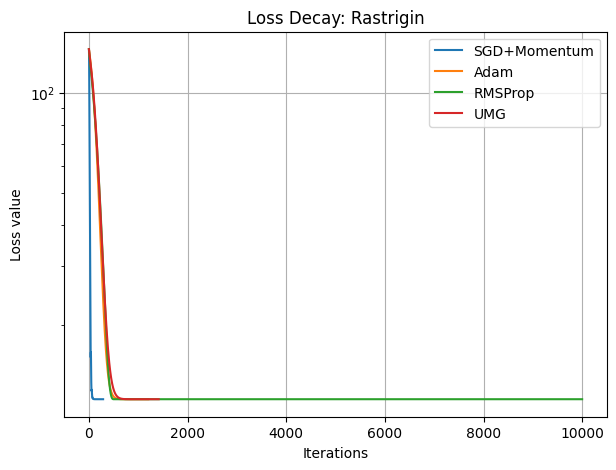

In [6]:

# ============================================================
# 5. Rastrigin
# ============================================================
print("\n--- Rastrigin ---")
x0 = np.random.randn(10)

optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, tol=1e-4),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, tol=1e-4),
    "UMG": lambda f, g, x0=x0: umg(f, g, x0, lr=0.001, tol=1e-4)
}

run_and_plot(rastrigin_f, rastrigin_grad,
             x0, optimizers, tol=1e-4, f_name="Rastrigin")


--- Ackley ---
Ackley | SGD+Momentum converged in 1669 iterations.
Ackley | Adam converged in 882 iterations.
Ackley | RMSProp converged in 10000 iterations.
Ackley | UMG converged in 1041 iterations.


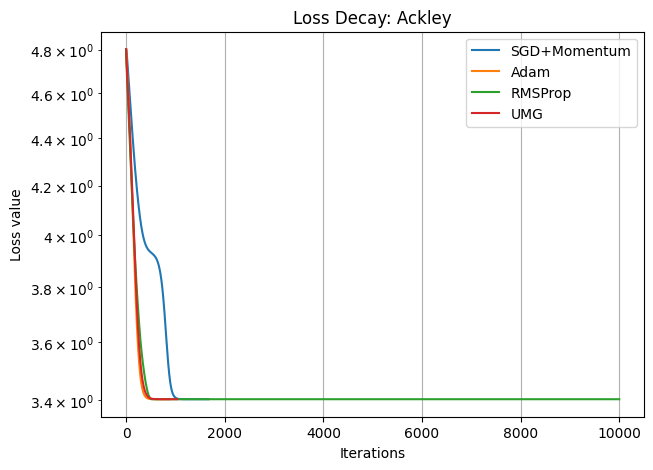

In [7]:

# ============================================================
# 6. Ackley
# ============================================================
print("\n--- Ackley ---")
x0 = np.random.randn(10)

optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, tol=1e-4),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, tol=1e-4),
    "UMG": lambda f, g, x0=x0: umg(f, g, x0, lr=0.001, tol=1e-4)
}

run_and_plot(ackley_f, ackley_grad,
             x0, optimizers, tol=1e-4, f_name="Ackley")


--- Himmelblau ---
Himmelblau | SGD+Momentum converged in 255 iterations.
Himmelblau | Adam converged in 4477 iterations.
Himmelblau | RMSProp converged in 10000 iterations.
Himmelblau | UMG converged in 4859 iterations.


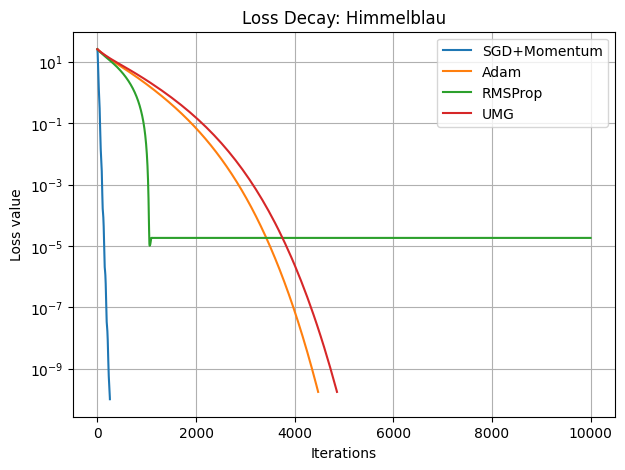

In [8]:

# ============================================================
# 7. Himmelblau
# ============================================================
print("\n--- Himmelblau ---")
x0 = np.array([3.0, 3.0])

optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, tol=1e-4),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, tol=1e-4),
    "UMG": lambda f, g, x0=x0: umg(f, g, x0, lr=0.001, tol=1e-4)
}

run_and_plot(himmelblau_f, himmelblau_grad,
             x0, optimizers, tol=1e-4, f_name="Himmelblau")

# Benchmark Function Descriptions

## 1. Rastrigin Function
**Type:** Non-convex, multimodal  
**Difficulty:** Many local minima, highly oscillatory  
**Formula:**
f(x) = A·n + Σ [ xᵢ² − A·cos(2πxᵢ) ],  A = 10

**Properties:**
- Very bumpy landscape  
- Many symmetric local minima  
- Global minimum at x = 0  
- Good for testing exploration and escaping shallow minima  

---

## 2. Ackley Function
**Type:** Non-convex, multimodal  
**Difficulty:** Flat region + steep basin  
**Formula:**
f(x) = -a·exp( -b·√( (1/n) Σ xᵢ² ) )  
        - exp( (1/n) Σ cos(c·xᵢ) ) + a + e  
with a = 20, b = 0.2, c = 2π

**Properties:**
- Nearly flat outer region → optimizers stall  
- Rapid drop into a narrow global basin  
- Many cosine-based local minima  
- Standard global optimization benchmark  

---

## 3. Himmelblau Function
**Type:** Non-convex, multiple global minima  
**Difficulty:** Several basins of attraction  
**Formula:**
f(x,y) = (x² + y − 11)² + (x + y² − 7)²

**Properties:**
- Four global minima  
- Several saddle points  
- Good for testing how well optimizers navigate multiple basins  
- Commonly used in visualization studies  

---
